# In-class Competition Tutorial (Hyperparameter Tuning)

Building on `tutorial_feature_engineering.ipynb`, this notebook focuses on tuning the hyperparameters of a CatBoost gradient boosting tree model more effectively by using Optuna to search for better configurations and improve its performance (ROC-AUC).

First, let's review the task we will be performing (see `README.ipynb` for details).

**Objective**: To predict the probability of default based on customer data.

**Evaluation metric**: ROC-AUC (Area Under the Receiver Operating Characteristic Curve)

## Contents
- [1.Setup](#scrollTo=a5KcDAE8CnmB)
- [2.Loading the Data](#scrollTo=3NuP1zcmCnmF&line=1&uniqifier=1)
- [3.Visualizing and Understanding the Data](#scrollTo=3NuP1zcmCnmF&line=1&uniqifier=1)
- [4.Preprocessing and Feature Creation](#scrollTo=rsPYkguwCnmO&line=1&uniqifier=1)
- [5.Advanced Feature Engineering](#scrollTo=GcaW-7a7ctm1&line=1&uniqifier=1)
- [6.Building the Machine Learning Model](#scrollTo=FoKdK60PCnmP&line=1&uniqifier=1)
- [7.Creating prediction results](#scrollTo=tn_kdvWYCnmQ&line=2&uniqifier=1)

## 1.Setup

### 1.1 Import Libraries
Let's load basic libraries.
Other required libraries will be loaded when we explain them.
- numpy: Library for efficient numerical computation
- pandas: Library useful for data analysis
- matplotlib: Graph drawing library
- seaborn: Graph drawing library as well

In [ ]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 1.2 Connect with Google Drive
To load the data, we first need to connect this Colab notebook with Google Drive.

In [ ]:
# If you work with Google Colaboratory, please run this as well.
from google.colab import drive
drive.mount('/content/drive')

Next, we need to navigate to where the `competition` folder is located

**IMPORTANT**:<br>
Change the path in the `%cd` command below to match the folder where this notebook is saved on Google Drive by **replacing "WhereThisNotebookIsLocated" with your actual folder path**.

Examples:
- You uploaded `competition` folder directly under MyDrive (the default folder when you open Google Drive)
    - Change to "/<wbr>content/drive/MyDrive/competition"
- You uploaded `competition` folder inside a folder named `00_GCIGlobal` under MyDrive
    - Change to "/<wbr>content/drive/MyDrive/00_GCIGlobal/competition"

You can easily locate your notebook's directory by:
1. Open the Files panel on the left side of Colab
2. Navigate through the "drive" and "MyDrive" folders until you find your notebook's folders
3. Click the more actions icon (three vertical dots, $\vdots$) next to the folder name
4. Select the option "Copy path"

In [ ]:
# Specify the directory where this notebook is located after %cd.
%cd "/content/drive/MyDrive/WhereThisNotebookIsLocated"

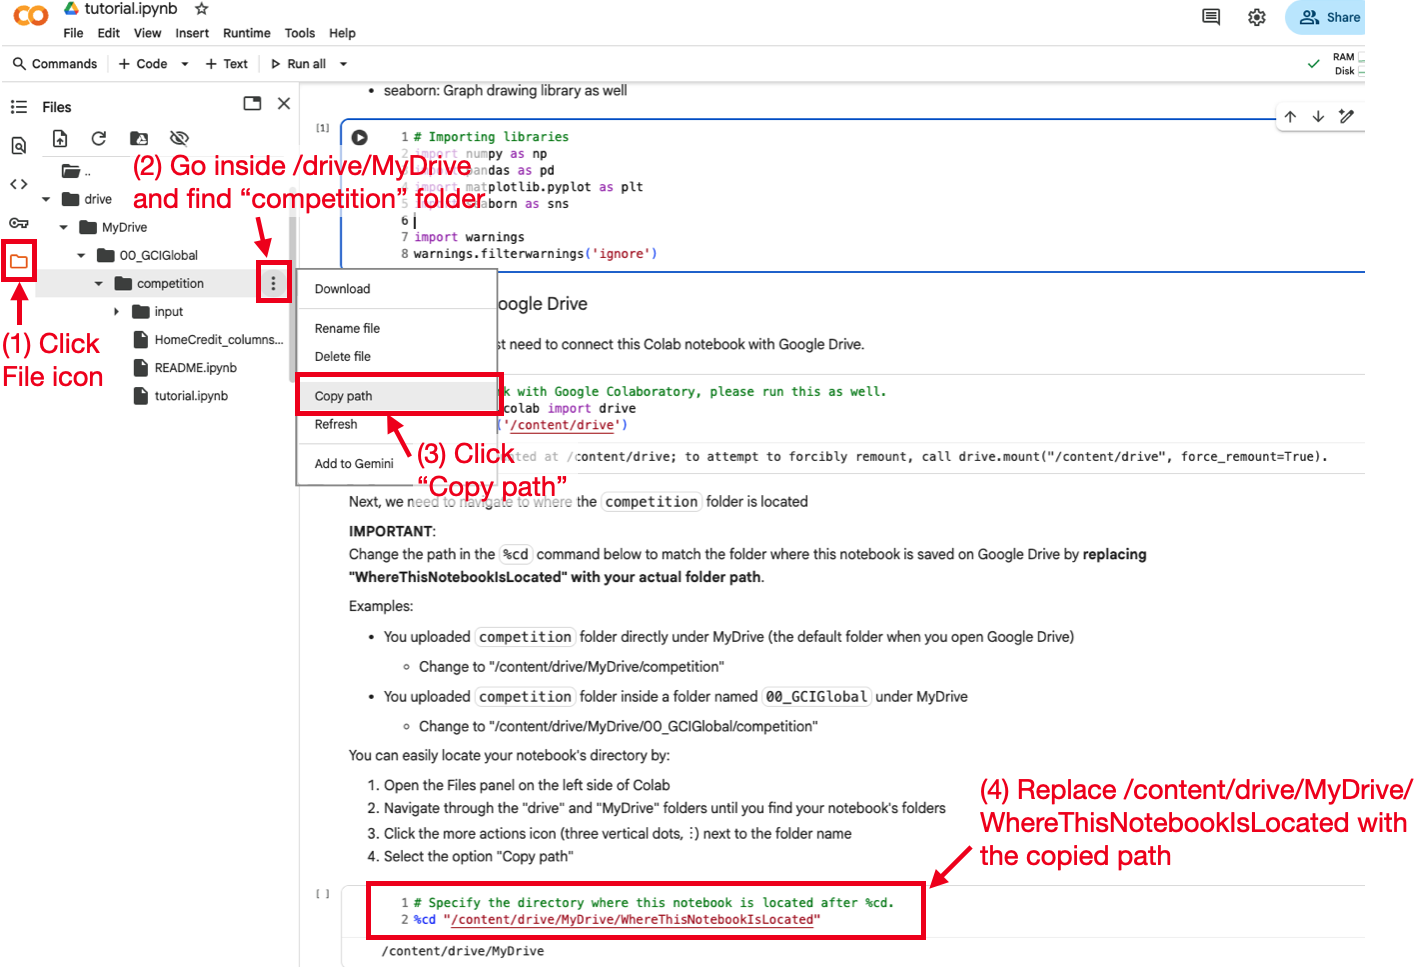

Run the cell below to check if the path is correctly set.

In [ ]:
import os
from pathlib import Path

# Automatically get the current working directory
current_dir = Path(os.getcwd())

# Define file paths using pathlib
train_file = current_dir / "input" / "train.csv"
test_file = current_dir / "input" / "test.csv"
sample_sub_file = current_dir / "input" / "sample_submission.csv"

# Check if path exists
if train_file.exists() and test_file.exists() and sample_sub_file.exists():
    print("All files exist and path is correctly set.")
else:
    print("Some files are missing or path is not correctly set.")

## 2.Loading the Data

### 2.1 Data Overview
Run the cell to load the dataset as `pd.DataFrame`.

**IMPORTANT:**<br>
**When you make modifications to preprocessing or model training, always make sure to run all cells from this cell.**

In [ ]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
sample_sub = pd.read_csv(sample_sub_file)

Before conducting a full-scale analysis, we will first review a brief overview of the data.

In [ ]:
# Check train data
print(f"train shape: {train.shape}")
train.head(3)

In [ ]:
# Check test data
print(f"test shape: {test.shape}")
test.head(3)

Excluding the `TARGET` column in train data and the `SK_ID_CURR` which represents ID number, you can see that there are 32 types of features.

###This time, we'll review all candidate features and use the majority in our model.

## 3.Visualizing and Understanding the Data

The first thing we need to do before building the machine learning model is to **understand the data**. We do this by visualizing and analyzing, to deepen our understanding of data distribution, missing values, outliers, correlations, and etc. The results of the analysis obtained at this stage will be useful for preprocessing, feature creation, and selection of machine learning models, which are all important to building models with better prediction ability.

### 3.1 Checking missing values
In this section, we check for missing values.
This is important as **most machine learning models cannot be trained on data with missing values**. If there are missing values, they need to be filled with some value.

In [ ]:
# Check missing values of train data
train.isnull().sum()

In [ ]:
# Check missing values of test data
test.isnull().sum()

We found that there are missing values in OWN_CAR_AGE, CNT_FAM_MEMBERS, EXT_SOURCE_\*, AMT_REQ_CREDIT_BUREAU_\*. We will deal with these missing values later.

### 3.2 Visualization and analysis of each feature
In this section, we visualize each feature and analyze to see what kind of characteristics it has.

#### TARGET column

In [ ]:
# The distribution of the target (default or not)
sns.countplot(data=train, x="TARGET")
plt.show()

We can see that the **distribution of the objective variable is highly skewed**. Data in which the distribution of the objective variable is highly skewed in this way is called **unbalanced data**.

When dealing with unbalanced data, we need to be particularly careful in selecting evaluation metrics. For example, if you choose accuracy, you will find that simply predicting all zeros will result in a high accuracy. **Choosing such an inappropriate metric can cause the machine learning model to fail to predict well on new data**.

Another approach to dealing with unbalanced data is to try to balance the distribution of the target variable. The method of reducing the data of the larger target variable is called undersampling, while the method of increasing the data of the smaller objective variable is called oversampling.

**Findings**:<br>
* (May) need to think about methods to mitigate the skewedness of the target variable

#### NAME_CONTRACT_TYPE column

In [ ]:
# The distribution of NAME_CONTRACT_TYPE
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")
plt.show()

There are two variables in NAME_CONTRACT_TYPE, Cash loans and Revolving loans, but they are not evenly distributed. Also, since the machine learning model can only handle data of numeric type, it is necessary to convert the data from string type to numeric type.

In [ ]:
# The distribution of ORGANIZATION_TYPE
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="ORGANIZATION_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

**Findings**:<br>
* (May) need to think about methods to mitigate the skewedness of the target variable
* Need to convert the data from string type to numeric type

#### ORGANIZATION_TYPE column

In [ ]:
# The distribution of ORGANIZATION_TYPE
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="ORGANIZATION_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

There are many different ORGANIZATION_TYPEs, and you can also see that there is an ununiformity in the number of data. This is also a string type feature, so it needs to be converted to a numeric type. Also, the second variable from the left is “XNA,” which we can infer from its name to be a missing value.


**Findings**:<br>
* Treat "XNA" as missing values
* Need to convert the data from string type to numeric type

#### EXT_SOURCE_1 column

In [ ]:
# The distribution of EXT_SOURCE_1
sns.displot(data=train, x="EXT_SOURCE_1")
plt.show()

#### EXT_SOURCE_2 column

In [ ]:
# The distribution of EXT_SOURCE_2
sns.displot(data=train, x="EXT_SOURCE_2")
plt.show()

#### EXT_SOURCE_3 column

In [ ]:
# The distribution of EXT_SOURCE_3
sns.displot(data=train, x="EXT_SOURCE_3")
plt.show()

We can see that EXT_SOURCE_\* is normalized between 0 and 1. It seems we can handle this feature as it is.

**Findings**:<br>
* No additional preprocessing is needed

#### AMT_INCOME_TOTAL

In [ ]:
# The distribution of AMT_INCOME_TOTAL
sns.displot(data=train, x="AMT_INCOME_TOTAL")
plt.show()

The visualization of `AMT_INCOME_TOTAL` is hard to interpret because the distribution is **right-skewed** with a small number of very large outliers. To visualize data like this, a logarithmic transformation can be effective.

In [ ]:
# The distribution of AMT_INCOME_TOTAL（Logarithmic transformation）
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

We displayed the graph successfully by using logarithmic transformation.
The income is supposed to be a continuous value, but it looks like a discrete value. Let's have a look at the type of `AMT_INCOME_TOTAL` values.

In [ ]:
# Check the type of AMT_INCOME_TOTAL values
len(train["AMT_INCOME_TOTAL"].unique())

There are 171202 data in train, but AMT_INCOME_TOTAL consists of only 1641 different values. Let's check the top 10 values specifically.

In [ ]:
# Top 10 values of AMT_INCOME_TOTAL
train["AMT_INCOME_TOTAL"].value_counts().head(10)

It appears that `AMT_INCOME_TOTAL` is not an exact annual income, but rather data compiled from a rounded number.

**Findings**:<br>
* Should the outlier in the data be addressed?

#### OWN_CAR_AGE

In [ ]:
# The distribution of OWN_CAR_AGE
sns.displot(data=train, x="OWN_CAR_AGE")
plt.show()

`OWN_CAR_AGE` can be inferred to be in years from the scale of values. In addition, the distribution is natural from 0 to 40, but there is an unnatural distribution around 60 to 70. It is hard to imagine that the number of years a car has been purchased increases suddenly like this, so they are considered to be outliers.

**Findings**:<br>
* Treat numbers above 60 as outliers

Up to this point, we have visualized and analyzed each feature. I believe that you have realized that visualization requires some ingenuity and that visualization can deepen your understanding of data. I am sure that the visualization and analysis of the 25 features not covered here will lead to improved forecasting accuracy.

### **[Next Steps]**
> + Visualize the features you have added. Is the feature categorical or continuous? What type of graph is most effective to understand it?
> + What do you notice about the features? What kind of preprocessing is needed?

## 4.Preprocessing and feature creation
Here, we will conduct the preprocessing and create new features based on what we have learned in the preceding visualization and analysis.

### NAME_CONTRACT_TYPE column
Convert `NAME_CONTRACT_TYPE` to a numeric type. In this case, “Cash loans” is converted to 0 and “Revolving loans” to 1. This method of simply replacing an integer is called **Label Encoding**.

In [ ]:
# Numerization of NAME_CONTRACT_TYPE（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)

### ORGANIZATION_TYPE column
Convert `ORGANIZATION_TYPE` to a numeric type. This time, we will convert the variable to numeric in terms of the number of data in the variable. For example, if the number of data in “Police” is 1279 and the number of data in “Bank” is 1385, convert “Police” to 1279 and “Bank” to 1385. This method of replacing the number of data with the number of data is called **Count Encoding**.

In [ ]:
# Numerization of ORGANIZATION_TYPE (Count Encoding）
organization_ce = train["ORGANIZATION_TYPE"].value_counts()
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)

train.head(5)

### EXT_SOURCE_* columns
Fill missing values in `EXT_SOURCE_1`, `EXT_SOURCE_2` and `EXT_SOURCE_3`. There are various methods for completing missing values, but in this case, since the number of missing values is small, we simply use the average value to complete the missing values.

**IMPORANT**:
When you fill the missing values in the test data, you need to **fill with the average of the train data**.

In [ ]:
# Complete missing values of EXT_SOURCE_* with the average
train["EXT_SOURCE_1"].fillna(train["EXT_SOURCE_1"].mean(), inplace=True)
test["EXT_SOURCE_1"].fillna(train["EXT_SOURCE_1"].mean(), inplace=True)
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
train["EXT_SOURCE_3"].fillna(train["EXT_SOURCE_3"].mean(), inplace=True)
test["EXT_SOURCE_3"].fillna(train["EXT_SOURCE_3"].mean(), inplace=True)

### CNT_FAM_MEMBERS column
We also fill missing values in `CNT_FAM_MEMBERS` with the mean.

In [ ]:
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].mean(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].mean(), inplace=True)

### AMT_REQ_CREDIT_BUREAU_* columns
Replace `NaN` in `AMT_REQ_CREDIT_BUREAU_*` with **0** in both `train` and `test`.
These columns are **counts** of bureau inquiries, so `0` naturally means “no inquiries.”
This avoids relying on training-set statistics (no leakage) and keeps schemas consistent.

In [ ]:
train["AMT_REQ_CREDIT_BUREAU_HOUR"].fillna(0, inplace=True)
test["AMT_REQ_CREDIT_BUREAU_HOUR"].fillna(0, inplace=True)
train["AMT_REQ_CREDIT_BUREAU_MON"].fillna(0, inplace=True)
test["AMT_REQ_CREDIT_BUREAU_MON"].fillna(0, inplace=True)
train["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(0, inplace=True)
test["AMT_REQ_CREDIT_BUREAU_QRT"].fillna(0, inplace=True)
train["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(0, inplace=True)
test["AMT_REQ_CREDIT_BUREAU_YEAR"].fillna(0, inplace=True)

train.isnull().sum()

### OWN_CAR_AGE column
First, we will replace the unnatural outliers that are over 60 as `np.nan` (missing values).

In [ ]:
# Treat values above 60 (outliers) in OWN_CAR_AGE as missing values.
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

Next, we consider the handling of missing values. The original `OWN_CAR_AGE` had 112992 missing values out of 171202 data. With such a large number of missing values, it is difficult and impractical to properly fill the missing values with some value. Therefore, we will group `OWN_CAR_AGE` by decade (e.g. Group 1: 0-9 years, Group 2: 10-19 years, etc.), then apply **One Hot Encoding**.

In [ ]:
# Divide OWN_CAR_AGE into groups
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()

In [ ]:
# Apply One Hot Encodiing to OWN_CAR_AGE
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)

### **[Next Steps]**
> + Apply preprocessing to the features you added. Is it correctly preprocessed?
> + Explore other preprocessing methods to apply to the features.
> + If you have errors, try reloading the dataset by going back to [Section 2.1](#scrollTo=jSh7uV_4CnmF&line=5&uniqifier=1).

## 5.Advanced Feature Engineering

The following cells defines a function `add_effective_features`. It **adds four features**, avoids target leakage, and keeps the feature set small.

**Features**

1. **LOG_AMT_INCOME_TOTAL**
   `log1p(AMT_INCOME_TOTAL)` to reduce strong right-skew in income.

2. **EXT_MEAN**
   Row-wise mean of available `EXT_SOURCE_1/2/3` to combine external risk scores.

3. **ANNUITY_INCOME_RATIO**
   `AMT_ANNUITY / AMT_INCOME_TOTAL` — higher means a heavier repayment burden.

4. **CREDIT_TERM**
   `AMT_CREDIT / AMT_ANNUITY` — rough number of payments (loan term proxy).

In [ ]:
from typing import Tuple, List
import numpy as np
import pandas as pd

def add_effective_features(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Add four compact features (numeric-only; no type coercion):
      - LOG_AMT_INCOME_TOTAL = log1p(AMT_INCOME_TOTAL)
      - EXT_MEAN             = row-mean of available EXT_SOURCE_1/2/3
      - ANNUITY_INCOME_RATIO = AMT_ANNUITY / AMT_INCOME_TOTAL
      - CREDIT_TERM          = AMT_CREDIT  / AMT_ANNUITY
    Returns: (train_new, test_new, new_feature_names)
    """
    tr, te = train.copy(), test.copy()
    new_cols: List[str] = []

    def add_feature(name: str, tr_v: pd.Series, te_v: pd.Series):
        tr[name] = tr_v
        te[name] = te_v
        new_cols.append(name)

    # 1) LOG_AMT_INCOME_TOTAL
    if 'AMT_INCOME_TOTAL' in tr.columns:
        tr_raw = np.log1p(tr['AMT_INCOME_TOTAL'])
        te_raw = np.log1p(te['AMT_INCOME_TOTAL'])
        add_feature('LOG_AMT_INCOME_TOTAL', tr_raw, te_raw)

    # 2) EXT_MEAN
    ext_cols = [c for c in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] if c in tr.columns]
    if ext_cols:
        tr_raw = tr[ext_cols].mean(axis=1, skipna=True)
        te_raw = te[ext_cols].mean(axis=1, skipna=True)
        add_feature('EXT_MEAN', tr_raw, te_raw)

    # 3) ANNUITY_INCOME_RATIO = AMT_ANNUITY / AMT_INCOME_TOTAL
    if {'AMT_ANNUITY', 'AMT_INCOME_TOTAL'}.issubset(tr.columns):
        tr_raw = tr['AMT_ANNUITY'] / tr['AMT_INCOME_TOTAL'].where(tr['AMT_INCOME_TOTAL'] > 0, np.nan)
        te_raw = te['AMT_ANNUITY'] / te['AMT_INCOME_TOTAL'].where(te['AMT_INCOME_TOTAL'] > 0, np.nan)
        add_feature('ANNUITY_INCOME_RATIO', tr_raw, te_raw)

    # 4) CREDIT_TERM = AMT_CREDIT / AMT_ANNUITY
    if {'AMT_CREDIT', 'AMT_ANNUITY'}.issubset(tr.columns):
        term_tr = tr['AMT_CREDIT'] / tr['AMT_ANNUITY'].where(tr['AMT_ANNUITY'] > 0, np.nan)
        term_te = te['AMT_CREDIT'] / te['AMT_ANNUITY'].where(te['AMT_ANNUITY'] > 0, np.nan)
        add_feature('CREDIT_TERM', term_tr, term_te)

    return tr, te, new_cols

# Apply feature engineering
train, test, _new_cols = add_effective_features(train, test)
print(f"Added {len(_new_cols)} engineered features:")
print(', '.join(_new_cols))

## 6.Building the Machine Learning Model
Now, we are ready to start building the machine learning model.

### 6.1 Import Additional Libraries
First, we import the necessary libraries for training and evaluation.

- `train_test_split`: Split data into training and evaluation data.
- `StandardScaler`: Standardize the data.
- `roc_auc_score`: Calculate ROC-AUC, the evaluation metric for this competition.

In [ ]:
# Loading libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

### 6.2 Preparing the Data
Split the data into features and the target using only numeric columns that exist in both train and test.
Since the target variable is TARGET, the remaining numeric columns become the explanatory variables.
This prevents errors from string/categorical values (e.g., "F") and guarantees the same feature schema for train and test.

In [ ]:
# Extract numeric (int/float) columns only and align to the columns common to train and test
num_cols_train = train.drop(columns=['TARGET']).select_dtypes(include=['number']).columns
num_cols_test  = test.select_dtypes(include=['number']).columns
num_cols = num_cols_train.intersection(num_cols_test)

# Build arrays using numeric columns only (ensure the same column order for train/test)
X = train[num_cols].values
y = train['TARGET'].values
X_test = test[num_cols].values

Standardize the data. Standardization is the operation of transforming the values so that the mean is 0 and the variance is 1. Some models, such as logistic regression and neural networks, do not learn well without scaling the values in this way.

In [ ]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_test_std = sc.transform(X_test)

We first split the training data into training data and validation data. This method of keeping a portion of the training data for evaluation and not using it for training is called the **holdout method**. This is one method to approximate the model's predictive ability on unknown data (**generalization** performance).

Here, we will use 70% of the data as training data and 30% as validation data

In [ ]:
# Split the original data into the training data and the evaluatioin data
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)

### 6.3 Training the Model using Hyperparameter Optimization with Optuna

Previously, we may have used Grid Search, which specifies exact values to test. Here, we will use **Optuna**, a more efficient Bayesian optimization library.

### Comparison: Why Optuna over Grid Search?

Both Grid Search and Optuna (using Bayesian Optimization) aim to find the best hyperparameters, but their "search strategy" is fundamentally different.

#### 1\. The Problems with Grid Search

Grid Search is a "brute force" method that tries every single combination.

  * **Explosive Computational Cost (Curse of Dimensionality)**:
    If you have 3 values for `depth`, 3 for `learning_rate`, and 3 for `l2_leaf_reg`, that's `3 * 3 * 3 = 27` trials. As parameters or values increase, the number of trials grows exponentially, making it impractical.
  * **Poor Handling of Continuous Values**:
    For a continuous value like `learning_rate`, you must pick discrete "points" to test (e.g., [0.01, 0.05, 0.1]). The true optimum (e.g., 0.08) will be missed if it's not in your grid.

#### 2\. How Optuna Solves This

Optuna "learns from past results to intelligently decide the next move."

  * **Efficient Search**:
    Optuna remembers every trial (e.g., "This combo gave 0.85 AUC," "That one gave 0.87 AUC"). It builds a model to predict, "Which area should I try next to get a better score?" (This is Bayesian Optimization).
  * **Fewer Trials**:
    By avoiding useless searches and focusing on promising regions, it can find high-performing parameters in far fewer trials (e.g., `n_trials=15`) than Grid Search.
  * **Flexible Search Space**:
    You can define `learning_rate` as a "range" like `[1e-3, 0.3]`.

#### 3\. Common Ground

Despite their differences, both methods share these common requirements:

  * **Human Defines the Search Space**: You must still decide which parameters to tune (e.g., `depth`) and the range to search within (e.g., `[4, 10]`).
  * **An Objective Metric is Defined**: You must decide what defines a "good model" (in our case, `ROC AUC`).
  * **A Validation Strategy is Defined**: You need a way to calculate that metric, either on a fixed validation set (`X_valid, y_valid`) or using K-Fold CV.

#### 4\. Simple Code Setup Comparison

Look at how the setup differs:

**Grid Search**
You must pass a `param_grid` dictionary of specific value lists.

```python
# You must list every "point" to try
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1.0, 10.0]
}
# This guarantees 3 * 3 * 2 = 18 trials

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3
)
grid_search.fit(X, y)
```

**Optuna**
You define an `objective` function that specifies the search range.

```python
def objective(trial):
    # You define the "range" to search
    # Optuna intelligently picks values from this range
    params = {
        'depth': trial.suggest_int('depth', 4, 8), # Any integer 4-8
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True), # Any float (log scale)
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0) # Any float 1.0-10.0
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    
    preds = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, preds)
    return auc # Optuna will try to maximize this

# Start the search and specify the number of trials (e.g., 18)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=18)
```

-----
Based on the Optuna approach, the following cells run a hyperparameter search for a CatBoost binary classifier with the following workflow.

1.  **Search space & trial setup**
      - `bootstrap_type ∈ {Bayesian, Bernoulli, MVS}`
      - Core tunables sampled by Optuna per trial:
          - `depth ∈ [4, 10]`
          - `learning_rate ∈ [1e-3, 0.3]` (log scale)
          - `l2_leaf_reg ∈ [1e-2, 1e2]` (log scale)
          - `random_strength ∈ [0.0, 2.0]`
          - `rsm ∈ [0.5, 1.0]` (column sampling)
          - `border_count ∈ [32, 255]`
          - `leaf_estimation_iterations ∈ [1, 10]`
          - If `bootstrap_type == "Bayesian"` → tune `bagging_temperature ∈ [0.0, 10.0]`
          - If `bootstrap_type == "Bernoulli"` → tune `subsample ∈ [0.5, 1.0]`
      - For more information, please refer to [CatBoost Documentation](https://catboost.ai/docs/en/references/training-parameters/)
2.  **Training configuration**
      - `iterations=4000` with `early_stopping_rounds=200` and `use_best_model=True`
      - `eval_metric="AUC"` on the validation pool
      - `auto_class_weights="Balanced"` for class imbalance
      - Determinism aided by `random_seed=0`
      - (Optional) enable GPU via `task_type="GPU"`
3.  **Objective**
      - Fit a model for each trial, predict validation probabilities, compute ROC AUC, and return it to Optuna
4.  **Optimization run**
      - `study.optimize(..., n_trials=15, show_progress_bar=True)`
      - After search, prints Best AUC and the corresponding Best params

### Notes & tips

  * For stronger estimates, consider **k-fold CV** (compute mean AUC per trial) instead of a single holdout.
  * You can speed up search with **pruning**: `optuna.integration.CatBoostPruningCallback("AUC", "Test")`.
  * If you have categorical features, ensure `cat_features` is correctly set (names or indices) for CatBoost to use them.
  * Increase `n_trials` for broader exploration.

We first install Optuna and CatBoost by running the following cell.

In [ ]:
!pip install -q optuna catboost

**The following cell takes quite a while to finish (around 30min), so you might want to decrease the number of iterations (to ~1000) or n_trials (to ~5).**

In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool

# If you have categorical columns, set them here (names or indices). Otherwise None.
cat_features = None  # e.g., X_train.select_dtypes('category').columns.tolist()

def objective(trial: optuna.trial.Trial) -> float:
    """Maximize AUC on the holdout (X_valid, y_valid)."""

    # Pick bootstrap_type first so we can add compatible params only
    bootstrap = trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])

    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        # Decrease the number of iterations for faster implementation
        "iterations": 4000,
        "early_stopping_rounds": 200,
        "use_best_model": True,
        "random_seed": 0,
        "verbose": False,
        "allow_writing_files": False,
        "auto_class_weights": "Balanced",
        "thread_count": -1,

        # Tuned hyperparameters
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 1e2, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.0, 2.0),
        "rsm": trial.suggest_float("rsm", 0.5, 1.0),                  # column sampling
        "border_count": trial.suggest_int("border_count", 32, 255),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "bootstrap_type": bootstrap,
        # "task_type": "GPU",  # enable if you run CatBoost on GPU
    }

    # Add only compatible options
    if bootstrap == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif bootstrap == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
    # MVS: no extra compatible knobs needed

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=valid_pool)

    pred = model.predict_proba(valid_pool)[:, 1]
    auc = roc_auc_score(y_valid, pred)
    return auc

# Run Optuna
study = optuna.create_study(direction="maximize", study_name="catboost_auc")
# Decrease the number of n_trials for faster implementation
study.optimize(objective, n_trials=15, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

### 6.4 Visualizing feature importance

We first rebuild a final set of CatBoost hyperparameters by combining fixed settings with the best parameters found by Optuna (`study.best_params`). Using these `best_params`, we create `Pool` objects for the training and validation data and fit a final `CatBoostClassifier` on them.

As before, we use the model’s `feature_importances_` attribute to plot feature importance and visualize which features the tuned CatBoost model relies on most.


In [ ]:
best_params = {
    # fixed params
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "iterations": 4000,
    "early_stopping_rounds": 200,
    "random_seed": 0,
    "verbose": False,
    "allow_writing_files": False,
    "use_best_model": True,
    "auto_class_weights": "Balanced",
    # tuned params
    **study.best_params,
}
train_pool = Pool(X_train, y_train, cat_features=cat_features)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=valid_pool)

In [ ]:
feature_names = list(num_cols)

def topk(df, k=30):
    return df.sort_values('importance', ascending=False).head(k)

def plot_importance(df, model_name, top_k=20):
    df_plot = (
        df.dropna(subset=["importance"])
          .sort_values("importance", ascending=False)
          .head(top_k)
    )
    if df_plot.empty:
        print(f"{model_name}: importance is empty or NaN only.")
        return

    plt.figure(figsize=(8, max(4, len(df_plot) * 0.35)))
    plt.barh(df_plot["feature"][::-1], df_plot["importance"][::-1])
    plt.title(f"{model_name} Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

try:
    cat_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": getattr(
            final_model,
            "feature_importances_",
            np.array([np.nan] * len(feature_names))
        )
    })
    plot_importance(cat_imp, "CatBoost")
except Exception as e:
    print("cat importance unavailable:", e)

Same as before, the newly added features (such as `EXT_MEAN` and `CREDIT_TERM`) appear important, indicating that they contribute meaningfully to the performance.

### **[Next Steps]**
> + Is holdout method the best method to evaluate your model?
> + Explore other models to use to make predictions.
> + If you have errors, try reloading the dataset by going back to [Section 2.1](#scrollTo=jSh7uV_4CnmF&line=5&uniqifier=1).

## 7.Creating Prediction Results
Finally, let's make a prediction for the test data, and prepare a CSV file to submit.

### 7.1 Predicting on the test data
We found in Sections 6.3 and 6.4 that the best model was the ensembling model. Therefore, we will use this model to make the final prediction.

In [ ]:
pred = final_model.predict_proba(X_test_std)[:, 1]
print("test pred shape:", pred.shape)

### 7.2 Saving the prediction as CSV file [DO NOT CHANGE]
**WARNING**: DO **NOT** CHANGE THE CODES BELOW!!!

In [ ]:
# Put the prediction into the format of submission
sample_sub['TARGET'] = pred
sample_sub

In [ ]:
# Create the "output" directory if it doesn't exist
output_dir = current_dir / "output"
os.makedirs(output_dir, exist_ok=True)

# Specify the new output file path
output_file = output_dir / "submission.csv"

# Save the CSV file to the "output" directory
sample_sub.to_csv(output_file, index=False)

### Wrap-Up

We ran **Optuna** to tune **CatBoost** for maximum ROC AUC on the validation split with early stopping.

**Results**
- Baseline CatBoost Valid AUC: **{0.750127}**
- Optuna-tuned Best Valid AUC: **{0.753014}**
- Improvement: **+{0.002887}**

**Takeaways**
- Searching over `bootstrap_type` (Bayesian/Bernoulli/MVS) plus core knobs (`depth`, `learning_rate`, `l2_leaf_reg`, `rsm`, etc.) yields a consistent AUC lift versus a fixed baseline.
- Early stopping (`use_best_model=True`, `early_stopping_rounds=200`) keeps training efficient and avoids overfitting.
- For more reliable estimates, prefer k-fold CV objectives over a single holdout.

**Next steps**
- Increase `n_trials` and enable **pruning** for faster search.
- If available, switch on **GPU** (`task_type="GPU"`) to explore larger spaces.
- Set `cat_features` (names/indices) so CatBoost can fully leverage categorical signals.

### **[Next Steps]**
Great, you've completed an initial n_trials=15 run with Optuna. This gives us a solid baseline. Here are concrete, practical next steps to take based on this result to further improve your model.

> * Use `plot_optimization_history` and `plot_param_importances` to check convergence and see which parameters were most impactful.
> * If a `best_param` hit your defined boundary (e.g., `depth: 10`), widen that parameter's range and search again.
> * If the history plot hasn't flattened out, should we run `study.optimize()` again to add more trials?
> * Can we speed up future searches by adding the `CatBoostPruningCallback` to stop unpromising trials early?
> * Would using K-Fold CV inside the `objective` function (instead of a single holdout set) find more robust and generalizable hyperparameters?